# FaceNet
- FaceNet is the name of the facial recognition system that was proposed by Google Researchers in 2015 in the paper titled FaceNet: A Unified Embedding for Face Recognition and Clustering

- Paper link : https://arxiv.org/abs/1503.03832

# Load libraries

In [61]:
from FaceNet_src.architecture import * 
import os 
from tqdm import tqdm
import cv2
import mtcnn
import pickle 
import numpy as np 
from sklearn.preprocessing import Normalizer
from tensorflow.keras.models import load_model
import random
import glob
import shutil
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

# Five classes/folders
CATEGORIES = ["aljadd", "nossaiba", "nouhaila", "langze"]

# Faces path
source_face_path = "dataset/"
destination_face_path = "FaceNet_src/Faces/"

In [62]:
# Empty Faces folder for new training if needed!
folder = 'FaceNet_src/Faces/'
for category in CATEGORIES:
    for filename in os.listdir(folder+category):
        file_path = os.path.join(folder+category, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [63]:
# Prepare images
number_of_faces_per_class = 15
for category in CATEGORIES:
    print(category)

    # Randomly take 5 images for training
    for c in random.sample(glob.glob(f'{source_face_path}{category}/{category}*'), number_of_faces_per_class):
        shutil.copy(c, f'{destination_face_path}/{category}')


aljadd
nossaiba
nouhaila
langze


In [111]:
# Needed functions
def normalize(img):
    mean, std = img.mean(), img.std()
    return (img - mean) / std

def get_face(img, box):
    x1, y1, width, height = box
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = img[y1:y2, x1:x2]
    return face, (x1, y1), (x2, y2)

def get_encode(face_encoder, face, size):
    face = normalize(face)
    face = cv2.resize(face, size)
    encode = face_encoder.predict(np.expand_dims(face, axis=0))[0]
    return encode


def load_pickle(path):
    with open(path, 'rb') as f:
        encoding_dict = pickle.load(f)
    return encoding_dict

def detect(img ,detector,encoder,encoding_dict, wanna_distance=False):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = detector.detect_faces(img_rgb)
    for res in results:
        if res['confidence'] < confidence_t:
            continue
        face, pt_1, pt_2 = get_face(img_rgb, res['box'])
        encode = get_encode(encoder, face, required_size)
        encode = l2_normalizer.transform(encode.reshape(1, -1))[0]
        name = 'unknown'

        distance = float("inf")
        for db_name, db_encode in encoding_dict.items():
            dist = cosine(db_encode, encode)
            if dist < recognition_t and dist < distance:
                name = db_name
                distance = dist

        if name == 'unknown':
            cv2.rectangle(img, pt_1, pt_2, (0, 0, 255), 2)
            cv2.putText(img, name, pt_1, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)
        else:
            cv2.rectangle(img, pt_1, pt_2, (0, 255, 0), 2)
            if wanna_distance:
                cv2.putText(img, name + f'__{distance:.2f}', (pt_1[0], pt_1[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1,
                            (0, 200, 200), 2)
            else:
                cv2.putText(img, name, (pt_1[0], pt_1[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 1,
                            (0, 200, 200), 2)
                
    return img 

In [65]:
# Load pretrained FaceNet
face_data = destination_face_path
required_shape = (160,160)
face_encoder = InceptionResNetV2()
path = "FaceNet_src/facenet_keras_weights.h5"
face_encoder.load_weights(path)
face_detector = mtcnn.MTCNN()
encodes = []
encoding_dict = dict()
l2_normalizer = Normalizer('l2')

In [66]:
# Training the model

for face_names in os.listdir(face_data):
    person_dir = os.path.join(face_data,face_names)

    for image_name in os.listdir(person_dir):
        image_path = os.path.join(person_dir,image_name)

        img_BGR = cv2.imread(image_path)
        img_RGB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

        x = face_detector.detect_faces(img_RGB)
        x1, y1, width, height = x[0]['box']
        x1, y1 = abs(x1) , abs(y1)
        x2, y2 = x1+width , y1+height
        face = img_RGB[y1:y2 , x1:x2]
        
        face = normalize(face)
        face = cv2.resize(face, required_shape)
        face_d = np.expand_dims(face, axis=0)
        encode = face_encoder.predict(face_d)[0]
        encodes.append(encode)

    if encodes:
        encode = np.sum(encodes, axis=0 )
        encode = l2_normalizer.transform(np.expand_dims(encode, axis=0))[0]
        encoding_dict[face_names] = encode
        
confidence_t=0.99
recognition_t=0.5
required_size = (160,160)

path = 'FaceNet_src/encodings/encodings.pkl'
with open(path, 'wb') as file:
    pickle.dump(encoding_dict, file)

# Test the model in real time

In [67]:
required_shape = (160,160)
face_encoder = InceptionResNetV2()
path_m = "FaceNet_src/facenet_keras_weights.h5"
face_encoder.load_weights(path_m)
encodings_path = 'FaceNet_src/encodings/encodings.pkl'
face_detector = mtcnn.MTCNN()
encoding_dict = load_pickle(encodings_path)

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret,frame = cap.read()

    if not ret:
        print("CAM NOT OPEND") 
        break

    frame = detect(frame , face_detector , face_encoder , encoding_dict, wanna_distance=True)

    cv2.imshow('camera', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
        
cap.release()
cv2.destroyAllWindows()

# Testing on new images

In [68]:
def predict(img ,detector,encoder,encoding_dict):
    label = ''
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = detector.detect_faces(img_rgb)
    for res in results:
        if res['confidence'] < confidence_t:
            continue
        face, pt_1, pt_2 = get_face(img_rgb, res['box'])
        encode = get_encode(encoder, face, required_size)
        encode = l2_normalizer.transform(encode.reshape(1, -1))[0]
        name = 'unknown'

        distance = float("inf")
        cv2.imwrite('face.jpg', face)
        for db_name, db_encode in encoding_dict.items():
            dist = cosine(db_encode, encode)
            if dist < recognition_t and dist < distance:
                name = db_name
                distance = dist

        if name == 'unknown':
            label = 4
        else:
            label = CATEGORIES.index(name)
    return label 

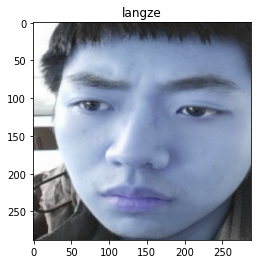

In [69]:
# Randomly choose an image
person =  random.choice(CATEGORIES)
for sample in random.sample(glob.glob(f'{source_face_path}{person}/{person}*'), 1):
    img = cv2.imread(sample)
plt.imshow(img)
# Display prediction in the title
plt.title(CATEGORIES[predict(img , face_detector , face_encoder , encoding_dict)])
plt.show()

In [70]:
# Empty Faces folder for new training if needed!
folder = 'FaceNet_src/Face_test/'
for category in CATEGORIES:
    for filename in os.listdir(folder+category):
        file_path = os.path.join(folder+category, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [71]:
# Prepare images for testing
number_of_faces_per_class_test = 5
test_face_path =  "FaceNet_src/Face_test/"
for category in CATEGORIES:
    print(category)

    # Randomly take 100 images for training
    for c in random.sample(glob.glob(f'{source_face_path}{category}/{category}*'), number_of_faces_per_class_test):
        shutil.copy(c, f'{test_face_path}/{category}')

aljadd
nossaiba
nouhaila
langze


In [72]:
# Calculate the testing accuracy
correct_prediciton = 0
test_img_total = number_of_faces_per_class_test*5
ind = 0
for person in CATEGORIES:
    person_path = test_face_path+person
    true_label = CATEGORIES.index(person)
    for img in tqdm(os.listdir(person_path)):
        img_full_path = os.path.join(person_path, img)
        image = cv2.imread(img_full_path)
        predicted_label = predict(image , face_detector , face_encoder , encoding_dict)
        if predicted_label == true_label:
            correct_prediciton += 1

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


In [130]:
def random_image(person_id):
    person = CATEGORIES[person_id]
    sample = random.sample(glob.glob(f'{source_face_path}{person}/{person}*'), 1)[0]
    sample = cv2.imread(sample)
    sample = cv2.resize(sample, (160, 160))
    return np.array(sample)

def random_4x4_image():
    randomlist = random.sample(range(0, 4), 4)
    ligne1 = cv2.hconcat([random_image(randomlist[0]), random_image(randomlist[1])])
    ligne2 = cv2.hconcat([random_image(randomlist[3]), random_image(randomlist[2])])
    image_6x6 = cv2.vconcat([ligne1, ligne2])
    image_6x6 = cv2.copyMakeBorder(image_6x6, 30, 30, 30, 30, cv2.BORDER_CONSTANT,value=[0,0,0])
    return image_6x6

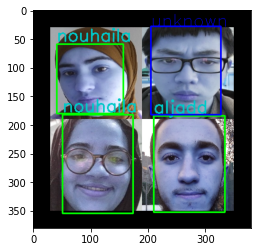

In [140]:
image_6x6 = random_4x4_image()
plt.imshow(detect(image_6x6 , face_detector , face_encoder , encoding_dict))
plt.show()